# Calculate Mass Uncertainty Function definition

In [1]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
import seaborn as sns
import matplotlib.pyplot as plt
import random
import scipy.signal as ss
import math
from detecta import detect_peaks

In [2]:
df = pd.read_csv("Example_Inputs/UncertaintyDf.csv")

The calculateMassUncertainty function takes a dataframe containing a processed spectrum with the following columns: formula, mz, observerd.  
It returns a dictionary with the uncertainty for each element calculated as the average of all the uncertainties for wich the element was present.  
By default it will take perform a weighted averged based on the number of elements in the compounds/ions.  
If weighted is set to False, it will only average the uncertainty based solely on the presence of the element.

In [47]:
from pyteomics import mass

def calculateMassUncertainty(processedSpectrum, weighted=True, dfOutput=True, show=False):
    data = [processedSpectrum["formula"],processedSpectrum["mz"]-processedSpectrum["observed"]]
    headers = ["formula", "uncertainty"]
    instance = pd.concat(data, axis=1, keys=headers)
    elements = {}
    for index, row in instance.iterrows():
        ion = row["formula"]
        ion = ion if ion[-1] != '-' else ion[:-1]
        tmp = mass.Composition(formula=ion)
        v = row["uncertainty"]
        total = sum(tmp.values())
        for e in tmp.keys():
            f = 1
            if weighted:
                f = tmp[e] / total
            if e not in elements:
                elements[e] = [v*f]
            else:
                elements[e].append(v*f)
    for e in elements.keys():
        elements[e] = sum(elements[e]) / len(elements[e])
    if show:
        keys = elements.keys()
        values = elements.values()
        plt.figure(1)
        plt.bar(keys, values)
    if dfOutput:
        df = pd.DataFrame(elements.items(), columns=['Element', 'Uncertainty'])
        return df
    else:
        return elements


<IPython.core.display.Javascript object>


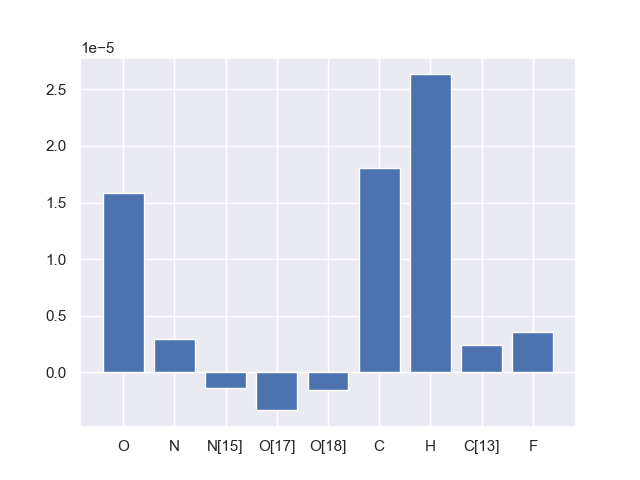

,Element,Uncertainty
0,O,0.000016
1,N,0.000003
2,N[15],-0.000001
3,O[17],-0.000003
4,O[18],-0.000002
5,C,0.000018
6,H,0.000026
7,C[13],0.000002
8,F,0.000004


In [48]:
%matplotlib notebook
#calculateMassUncertainty(df)
calculateMassUncertainty(df, True, True,True)

# Experiments with the function above
Here I try to graph the uncertainty for each element from all the spectra in the first small deviation file.  
If you want to try, just change the folder variable below.

**Important** Since this function requires processed spectra I am using Koli's code for that part. It is implemented with copy paste at the end, so run those cells before running mine.

In [ ]:
folder = spectrum_data_directory = "C:/Users/Antonio/Google Drive/Orbitrap project/Data//CI-orbi_20201117165601 folder (first smal deviation file)/2 mins"
peak_list_file = "C:/Users/Antonio/Desktop/Esercizi prog/Data science project/peak list/peaklist_1e5_background.csv"

spectrum_data_files = []
spectrum_data = []

# Get data files
for file in [f for f in listdir(folder) if isfile(join(folder, f))]:
    path_to_file = join(folder, file)
    #print(path_to_file)
    if file.endswith(".csv"):
        spectrum_data_files.append(path_to_file)
for file in spectrum_data_files:
    spectrum_data.append(readFile(file))

peak_list = pd.read_csv(peak_list_file)

In [ ]:
identified_spectra = []
uncertaintydf = pd.DataFrame({'Element' : [], 'Uncertainty' : []})
dfs = []
for i in range(len(spectrum_data)):
    identified_spectra.append(identifyPeaks(spectrum_data[i], peak_list, 0.002))
    dfs.append(calculateMassUncertainty(identified_spectra[i]))

In [42]:
uncertaintydf = pd.DataFrame({'Element' : [], 'Uncertainty' : []})
for i in range(1, len(dfs)):
    uncertaintydf = uncertaintydf.append(dfs[i], ignore_index = True)
uncertaintydf

,Element,Uncertainty
0,C,1.794696e-05
1,H,2.604384e-05
2,O,1.672390e-05
3,N,3.554998e-06
4,N[15],-3.259635e-06
...,...,...
270,O[18],-3.995968e-09
271,C,8.760330e-06
272,H,1.404264e-05
273,F,-1.452507e-05


<IPython.core.display.Javascript object>


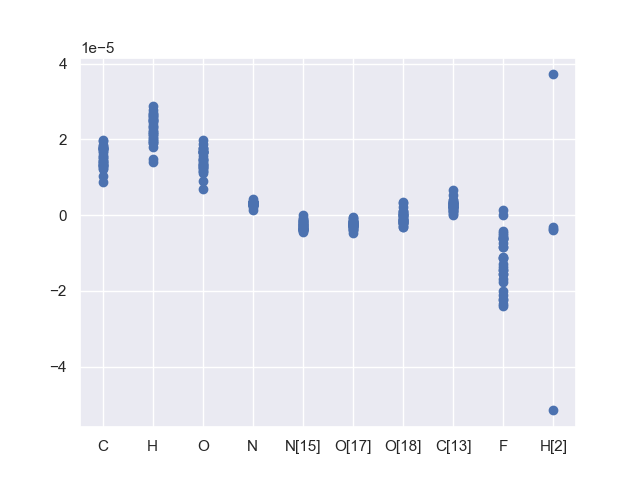

In [46]:
names = uncertaintydf["Element"]
values = uncertaintydf["Uncertainty"]
plt.figure(2)
sns.set()
plt.scatter(names, values)

## Koli's code for identifying peaks
Imported Koli's code for identifying peaks. Run this before the cell above.  
I tried using 
```python
from ipynb.fs.full.<notebook_name> import <function_name>
```
but I wasn't able to make it work so I just copy pasted the cells.  
[An alternative](https://stackoverflow.com/questions/54317381/selectively-import-from-another-jupyter-notebook) that I didn't look much into was to import specific cells, but as I said, I didn't tried it very much

In [22]:
import numpy as np
import pandas as pd

def readFile(fileName):
    return pd.read_csv(fileName).iloc[1:,:2].to_numpy().astype("float64")

In [29]:
import numpy as np

def findPeakIndices(data):
    n = int(round(sum(data[:,1] == 0)/2))
    indices = np.zeros([n+1,2], dtype="uint32")
    a = False
    ii = 0
    for i in range(len(data[:,1])-1):
        if data[i,1] == 0 and a:
            indices[ii, 1] = i - 1
            if ii != n:
                indices[ii+1, 0] = i
            ii += 1
        a = data[i,1] == 0
    last = n-sum(indices[:,0]>=indices[:,1])
    indices = indices[0:last+1,:]
    indices[last, 1] = len(data[:,0]) - 1
    return indices

In [16]:
from scipy.optimize import leastsq
import numpy as np

def getMean(peak):
    mu = np.average(peak[:,0], weights=peak[:,1])
    sigma = (mu/280000)/(2*np.log(2))
    fitfunc  = lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/sigma)**2)
    errfunc  = lambda p, x, y: (y - fitfunc(p, x))
    init  = [1.0, mu]
    out = leastsq(errfunc, init, args=(peak[:,0], peak[:,1]))
    c = out[0]
    return c[1]

In [17]:
import numpy as np

def getAllMeans(peaks):
    indices = findPeakIndices(peaks)
    n = len(indices[:,0])
    means = np.zeros(n)
    for i in range(n):
        peak = peaks[indices[i,0]:indices[i,1]+1,:]
        means[i] = getMean(peak)
    return means

In [18]:
import pandas as pd
import numpy as np

def identifyPeaks(data, peaklist, th):
    peaklist['observed'] = np.zeros(len(peaklist['mz']))
    peaklist['peak'] = np.zeros(len(peaklist['mz']))
    peakMeans = getAllMeans(data)
    trueValue = peaklist['mz'].to_numpy()
    for i in range(len(trueValue)):
        if min(abs(peakMeans - trueValue[i])) < th:
            peaklist.iloc[i,2] = peakMeans[np.argmin(abs(peakMeans - trueValue[i]))]
            peaklist.iloc[i,3] = np.argmin(abs(peakMeans - trueValue[i]))
    unidentified = np.linspace(0, len(trueValue)-1, len(trueValue))
    unidentified = unidentified[peaklist['observed'].to_numpy() == 0]
    return peaklist.drop(unidentified)